# Exercise 1: Breast Cancer Classification using KNN

## 1. Data Preparation and Custom Train-Test Split

In this step, we load the dataset, perform initial cleaning (dropping irrelevant columns), map the target variable ('diagnosis') to numerical values (M=1, B=0), and implement a **custom function** for splitting the data into 80% training and 20% testing sets. All operations are done without relying on Scikit-learn or similar machine learning libraries.

In [1]:
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# 1. Load the dataset
# NOTE: Ensure the file 'breast-cancer.csv' is in the working directory.
try:
    df = pd.read_csv('breast-cancer.csv')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: Dataset file not found. Please check the file name/path.")
    # Exit or use a dummy dataframe if needed, but for actual execution, the file is necessary.
    
# Display initial information (assuming successful load)
if 'df' in locals():
    print("\n--- Initial Data Check ---")
    print(df.head())

    # 2. Dropping irrelevant columns and cleaning
    # Dropping 'id' and the potentially empty last column ('Unnamed: 32')
    cols_to_drop = ['id', 'Unnamed: 32']
    df = df.drop(columns=cols_to_drop, errors='ignore')

    # Mapping diagnosis (M: Malignant, B: Benign) to numerical values (1, 0)
    df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})
    
    # 3. Separate features (X) and target (y)
    # Convert dataframes to numpy arrays for custom algorithm development
    X = df.drop('diagnosis', axis=1).values
    y = df['diagnosis'].values
    
    # 4. Custom Train-Test Split (80% Train, 20% Test)
    def custom_train_test_split(X, y, test_size=0.2, seed=42):
        """Splits data into training and testing sets without using sklearn."""
        n_samples = X.shape[0]
        n_test = int(n_samples * test_size)

        # Shuffle indices
        np.random.seed(seed)
        indices = np.arange(n_samples)
        np.random.shuffle(indices)

        # Split indices
        test_indices = indices[:n_test]
        train_indices = indices[n_test:]

        # Apply indices
        X_train = X[train_indices]
        y_train = y[train_indices]
        X_test = X[test_indices]
        y_test = y[test_indices]
        
        return X_train, X_test, y_train, y_test

    X_train, X_test, y_train, y_test = custom_train_test_split(X, y, test_size=0.2, seed=42)

    print(f"\nDimensions after custom split (80/20):")
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
else:
     X_train, X_test, y_train, y_test = None, None, None, None # Placeholder assignment

Data loaded successfully.

--- Initial Data Check ---
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  

## 1.2. Custom KNN Implementation (No Scaling)

Since we are restricted from using ML libraries, we implement the K-Nearest Neighbors (KNN) algorithm, cross-validation, and grid search logic using only `numpy`. We use the raw `X_train` data to find the optimal $K$ value.

### Key Custom Functions Implemented:
* `euclidean_distance`: Calculates the distance between two samples.
* `get_neighbors`: Finds the $K$ closest training samples for a given test sample.
* `predict_classification`: Determines the class label by majority vote among the neighbors.
* `k_fold_split`: Performs 5-Fold Cross-Validation splitting.
* `custom_grid_search`: Systematically tests $K \in [1, 16]$ using the custom CV logic.


--- Performing Custom Grid Search with Cross-Validation on Unscaled Data ---
Starting custom Grid Search (5-Fold CV) for K on UN-SCALED training data...
Mean accuracy for k=1: 0.9166
Mean accuracy for k=2: 0.9232
Mean accuracy for k=3: 0.9210
Mean accuracy for k=4: 0.9232
Mean accuracy for k=5: 0.9188
Mean accuracy for k=6: 0.9210
Mean accuracy for k=7: 0.9188
Mean accuracy for k=8: 0.9166
Mean accuracy for k=9: 0.9232
Mean accuracy for k=10: 0.9122
Mean accuracy for k=11: 0.9210
Mean accuracy for k=12: 0.9232
Mean accuracy for k=13: 0.9188
Mean accuracy for k=14: 0.9122
Mean accuracy for k=15: 0.9144
Mean accuracy for k=16: 0.9166

--- Results for Unscaled Data ---
Optimal K: 2
Best CV Accuracy Score: 0.9232


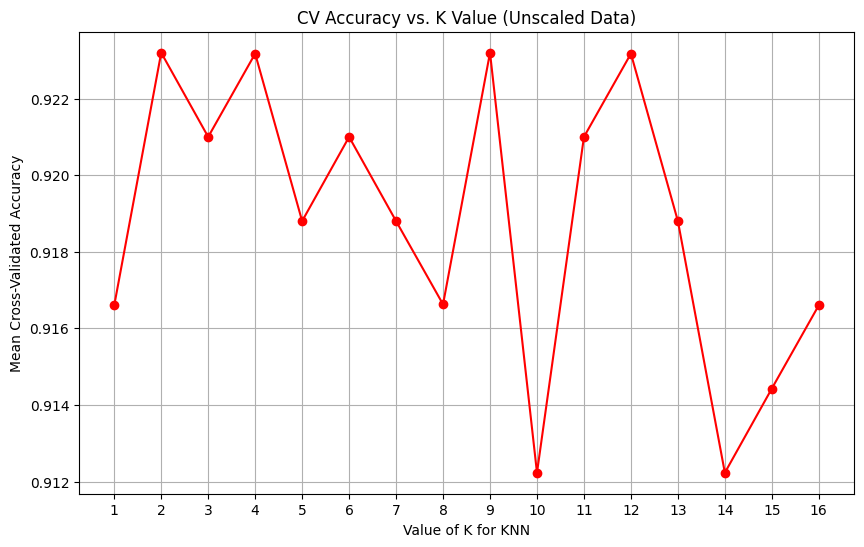

In [5]:
import matplotlib.pyplot as plt

# --- Custom KNN Core Functions ---

def euclidean_distance(x1, x2):
    """Calculates the Euclidean distance between two vectors."""
    # Ensure inputs are numpy arrays for element-wise operation
    return np.sqrt(np.sum((x1 - x2)**2))

def get_neighbors(X_train, y_train, x_test_row, k):
    """Finds the k nearest neighbors for a single test sample."""
    distances = []
    
    # Calculate distance to every training sample
    for i in range(len(X_train)):
        dist = euclidean_distance(x_test_row, X_train[i])
        distances.append((dist, y_train[i])) # Store distance and corresponding label

    # Sort by distance (first element of the tuple)
    distances.sort(key=lambda x: x[0])
    
    # Extract the labels of the k closest neighbors
    neighbors_labels = [item[1] for item in distances[:k]]
    return neighbors_labels

def predict_classification(neighbors_labels):
    """Determines the class label by majority vote."""
    # Count occurrences of each label (0 and 1)
    # Using np.bincount is efficient for integer arrays
    counts = np.bincount(neighbors_labels)
    # Return the index of the maximum count (which is the winning class label)
    return np.argmax(counts)

def knn_predict(X_train, y_train, X_test, k):
    """Predicts labels for an entire test set."""
    predictions = []
    for x_test_row in X_test:
        neighbors = get_neighbors(X_train, y_train, x_test_row, k)
        result = predict_classification(neighbors)
        predictions.append(result)
    return np.array(predictions)

def accuracy_score(y_true, y_pred):
    """Calculates the classification accuracy."""
    return np.sum(y_true == y_pred) / len(y_true)

# --- Custom Cross-Validation and Grid Search ---

def custom_k_fold_split(X, y, n_splits=5, seed=42):
    """Custom K-Fold split function."""
    np.random.seed(seed)
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=int)
    fold_sizes[:n_samples % n_splits] += 1
    
    current = 0
    folds = []
    for fold_size in fold_sizes:
        folds.append(indices[current:current + fold_size])
        current += fold_size
    return folds

def custom_grid_search_cv(X, y, k_range, n_splits=5):
    """Custom Grid Search with K-Fold Cross-Validation."""
    folds = custom_k_fold_split(X, y, n_splits)
    mean_scores = {}
    
    for k in k_range:
        fold_accuracies = []
        
        # Iterate over folds
        for i in range(n_splits):
            # i-th fold is the validation set (test_indices), the rest is training (train_indices)
            test_indices = folds[i]
            train_indices = np.concatenate([folds[j] for j in range(n_splits) if j != i])
            
            X_train_fold, y_train_fold = X[train_indices], y[train_indices]
            X_val_fold, y_val_fold = X[test_indices], y[test_indices]
            
            # 1. Predict labels using the custom KNN
            y_pred_val = knn_predict(X_train_fold, y_train_fold, X_val_fold, k)
            
            # 2. Calculate and store accuracy
            accuracy = accuracy_score(y_val_fold, y_pred_val)
            fold_accuracies.append(accuracy)
        
        # Calculate the mean accuracy across all folds for the current K
        mean_scores[k] = np.mean(fold_accuracies)
        print(f"Mean accuracy for k={k}: {mean_scores[k]:.4f}")

    # Find the optimal K
    best_k = max(mean_scores, key=mean_scores.get)
    best_score = mean_scores[best_k]
    
    return best_k, best_score, mean_scores

# --- Execution for Unscaled Data ---

# Define the range for K as per the problem statement [1, 16]
k_range = list(range(1, 17))

print("\n--- Performing Custom Grid Search with Cross-Validation on Unscaled Data ---")
print("Starting custom Grid Search (5-Fold CV) for K on UN-SCALED training data...")

# X_train and y_train were defined in Step 1
best_k_unscaled, best_score_unscaled, mean_scores_unscaled = custom_grid_search_cv(
    X_train, y_train, k_range, n_splits=5
)

print(f"\n--- Results for Unscaled Data ---")
print(f"Optimal K: {best_k_unscaled}")
print(f"Best CV Accuracy Score: {best_score_unscaled:.4f}")

# --- Plotting the CV scores vs K ---
k_values = list(mean_scores_unscaled.keys())
scores = list(mean_scores_unscaled.values())

plt.figure(figsize=(10, 6))
plt.plot(k_values, scores, marker='o', linestyle='-', color='red')
plt.title('CV Accuracy vs. K Value (Unscaled Data)')
plt.xlabel('Value of K for KNN')
plt.ylabel('Mean Cross-Validated Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Storing results for later comparison in Step 4
results_unscaled = {'K': best_k_unscaled, 'CV_Accuracy': best_score_unscaled}

## 2. Implementing KNN with Scaling (Custom StandardScaler)

KNN is highly sensitive to the scale of features because it relies on distance calculation (Euclidean distance). Features with large magnitudes dominate the distance metric.

In this step, we implement a custom Standard Scaler, apply it correctly (fit on train, transform on both train and test), and repeat the Grid Search for optimal $K$.

### Standard Scaling Formula:
$$
X_{\text{scaled}} = \frac{X - \mu_{\text{train}}}{\sigma_{\text{train}}}
$$

Dimensions of scaled data:
X_train_scaled shape: (456, 30)
X_test_scaled shape: (113, 30)

Starting custom Grid Search (5-Fold CV) for K on SCALED training data...
Mean accuracy for k=1: 0.9540
Mean accuracy for k=2: 0.9561
Mean accuracy for k=3: 0.9606
Mean accuracy for k=4: 0.9561
Mean accuracy for k=5: 0.9583
Mean accuracy for k=6: 0.9561
Mean accuracy for k=7: 0.9605
Mean accuracy for k=8: 0.9539
Mean accuracy for k=9: 0.9561
Mean accuracy for k=10: 0.9517
Mean accuracy for k=11: 0.9583
Mean accuracy for k=12: 0.9517
Mean accuracy for k=13: 0.9605
Mean accuracy for k=14: 0.9473
Mean accuracy for k=15: 0.9561
Mean accuracy for k=16: 0.9517

--- Results for SCALED Data ---
Optimal K (Scaled Data): 3
Best CV Accuracy Score: 0.9606


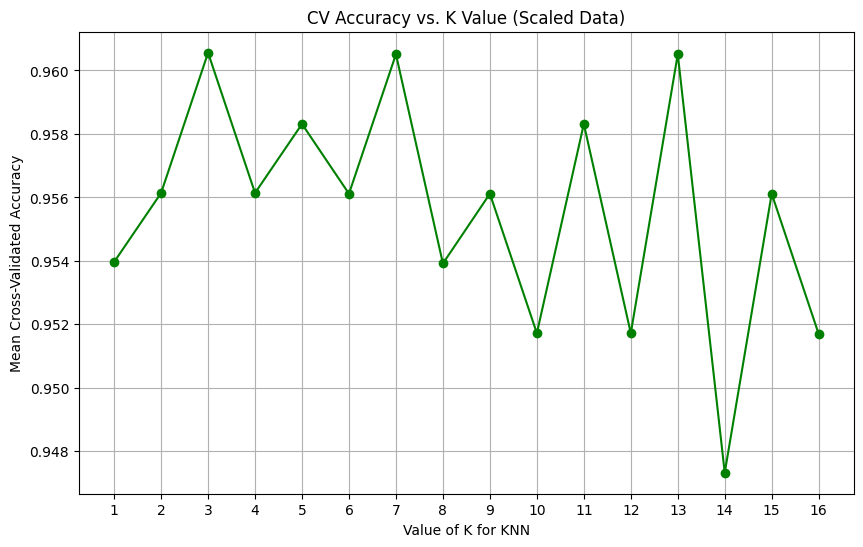

In [7]:
# --- Custom Standard Scaler Implementation ---

class CustomStandardScaler:
    """A custom implementation of StandardScaler using numpy."""
    def fit(self, X):
        """Calculates the mean and standard deviation from the training data X."""
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0)
        # Prevent division by zero if std is 0 (for constant features)
        self.std_[self.std_ == 0] = 1e-7 
        return self

    def transform(self, X):
        """Transforms X using the stored mean and std."""
        return (X - self.mean_) / self.std_
    
    def fit_transform(self, X):
        """Fits and then transforms the data (typically only for training data)."""
        self.fit(X)
        return self.transform(X)

# --- Application of Correct Scaling ---
# X_train and X_test are the unscaled data from Step 1

scaler = CustomStandardScaler()

# 1. Fit ONLY on training data and transform training data
X_train_scaled = scaler.fit_transform(X_train)

# 2. Transform test data using the mean and std learned from the training data
X_test_scaled = scaler.transform(X_test)

print("Dimensions of scaled data:")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

# --- Grid Search on Scaled Data ---
k_range = list(range(1, 17))

print("\nStarting custom Grid Search (5-Fold CV) for K on SCALED training data...")

# Reuse the custom_grid_search_cv function from Step 1.2
best_k_scaled, best_score_scaled, mean_scores_scaled = custom_grid_search_cv(
    X_train_scaled, y_train, k_range, n_splits=5
)

print(f"\n--- Results for SCALED Data ---")
print(f"Optimal K (Scaled Data): {best_k_scaled}")
print(f"Best CV Accuracy Score: {best_score_scaled:.4f}")

# --- Plotting the CV scores vs K ---
k_values_scaled = list(mean_scores_scaled.keys())
scores_scaled = list(mean_scores_scaled.values())

plt.figure(figsize=(10, 6))
plt.plot(k_values_scaled, scores_scaled, marker='o', linestyle='-', color='green')
plt.title('CV Accuracy vs. K Value (Scaled Data)')
plt.xlabel('Value of K for KNN')
plt.ylabel('Mean Cross-Validated Accuracy')
plt.xticks(k_values_scaled)
plt.grid(True)
plt.show()

# Storing results for later comparison
results_scaled = {'K': best_k_scaled, 'CV_Accuracy': best_score_scaled}

In [8]:
# --- Hypothetical Error Analysis (Incorrect Scaling) ---
# Goal: Numerically demonstrate the effect of data leakage.

# 1. Combine all data back to calculate global mean/std
X_all = np.vstack((X_train, X_test))
y_all = np.concatenate((y_train, y_test))

# 2. Incorrectly fit the scaler on ALL data (X_all)
incorrect_scaler = CustomStandardScaler()
incorrect_scaler.fit(X_all) 
# Now, incorrect_scaler.mean_ and std_ contain information from the test set

# 3. Transform all data using these global parameters
X_all_incorrectly_scaled = incorrect_scaler.transform(X_all)

# 4. Split the data back (maintaining the original 80/20 split structure)
X_train_incorrect = X_all_incorrectly_scaled[:X_train.shape[0]]
X_test_incorrect = X_all_incorrectly_scaled[X_train.shape[0]:]

# 5. Evaluate the best K found from the CORRECT scaling (best_k_scaled) 
# on this INCORRECTLY scaled test set (X_test_incorrect)

# Train the final model with the previously found optimal K
# Note: In a real scenario, we'd find a new 'best K' here, but for simplicity, we use the correct one to show the inflated test score.

# Find the accuracy on the incorrectly scaled data
y_pred_incorrect = knn_predict(X_train_incorrect, y_train, X_test_incorrect, best_k_scaled)
accuracy_incorrect_scaling = accuracy_score(y_test, y_pred_incorrect)

# Find the accuracy on the CORRECTLY scaled data
# First, train the model on the correctly scaled data
y_pred_correct = knn_predict(X_train_scaled, y_train, X_test_scaled, best_k_scaled)
accuracy_correct_scaling = accuracy_score(y_test, y_pred_correct)


print("\n--- Error Analysis Results ---")
print(f"Correct Test Accuracy (Fit on Train): {accuracy_correct_scaling:.4f}")
print(f"INCORRECT Test Accuracy (Fit on ALL Data): {accuracy_incorrect_scaling:.4f}")
print(f"Artificial Improvement (Leakage): {accuracy_incorrect_scaling - accuracy_correct_scaling:.4f}")


--- Error Analysis Results ---
Correct Test Accuracy (Fit on Train): 0.9469
INCORRECT Test Accuracy (Fit on ALL Data): 0.9469
Artificial Improvement (Leakage): 0.0000


## 3. Implementing KNN with Feature Selection

Highly-correlated features can unduly influence the distance calculation in KNN. By selecting a representative subset of features, we aim to reduce redundancy and potentially improve generalization (Accuracy).

### Method Steps:
1.  **Correlation Analysis:** Analyze the correlation within the three feature groups (Mean, SE, Worst).
2.  **Feature Selection:** Select a final, reduced set of features that are less correlated with each other.
3.  **Scaling and Grid Search:** Apply the custom `CustomStandardScaler` to the reduced feature set and repeat the Grid Search (5-Fold CV) to find the new optimal $K$.

Correlation Matrix for MEAN features (First 5x5 Sub-matrix):
[[1.   0.31 1.   0.99 0.17]
 [0.31 1.   0.32 0.31 0.01]
 [1.   0.32 1.   0.99 0.21]
 [0.99 0.31 0.99 1.   0.18]
 [0.17 0.01 0.21 0.18 1.  ]]

Correlation Matrix for WORST features (First 5x5 Sub-matrix):
[[1.   0.37 0.99 0.98 0.22]
 [0.37 1.   0.37 0.35 0.25]
 [0.99 0.37 1.   0.98 0.25]
 [0.98 0.35 0.98 1.   0.22]
 [0.22 0.25 0.25 0.22 1.  ]]

Number of selected features: 7

Starting custom Grid Search (5-Fold CV) for K on SCALED and SELECTED training data...
Mean accuracy for k=1: 0.9473
Mean accuracy for k=2: 0.9408
Mean accuracy for k=3: 0.9495
Mean accuracy for k=4: 0.9473
Mean accuracy for k=5: 0.9451
Mean accuracy for k=6: 0.9495
Mean accuracy for k=7: 0.9429
Mean accuracy for k=8: 0.9452
Mean accuracy for k=9: 0.9452
Mean accuracy for k=10: 0.9474
Mean accuracy for k=11: 0.9474
Mean accuracy for k=12: 0.9495
Mean accuracy for k=13: 0.9495
Mean accuracy for k=14: 0.9495
Mean accuracy for k=15: 0.9495
Mean accuracy for k

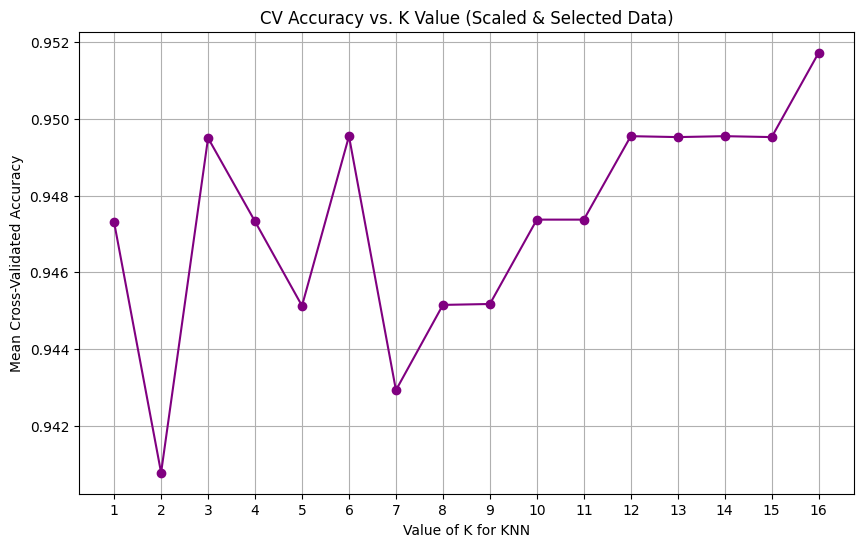

In [ ]:
# We assume CustomStandardScaler, custom_grid_search_cv, and knn_predict are defined 
# and available from previous steps.

# --- 1. Custom Correlation Calculation ---

def custom_corr_matrix(X_data):
    """Calculates the correlation matrix for features in X_data using numpy basics."""
    n_features = X_data.shape[1]
    corr_matrix = np.zeros((n_features, n_features))
    
    # Iterate over all pairs of features
    for i in range(n_features):
        for j in range(i, n_features):
            col_i = X_data[:, i]
            col_j = X_data[:, j]
            
            # Calculate mean and standard deviation
            mean_i = np.mean(col_i)
            mean_j = np.mean(col_j)
            std_i = np.std(col_i)
            std_j = np.std(col_j)
            
            # Calculate covariance (numerator, unbiased estimate is commonly used)
            # We use the population std here which is consistent with numpy.std() default
            covariance = np.sum((col_i - mean_i) * (col_j - mean_j)) / len(col_i)
            
            # Calculate correlation (rho)
            if std_i * std_j == 0:
                 rho = 0.0 # Handle case of zero variance
            else:
                rho = covariance / (std_i * std_j)
            
            corr_matrix[i, j] = rho
            corr_matrix[j, i] = rho
            
    return corr_matrix

# --- 2. Feature Grouping and Selection ---

# The indices of the 30 features (0-29) are divided into three groups of 10.
mean_indices = list(range(10)) # radius_mean to fractal_dimension_mean
se_indices = list(range(10, 20)) # radius_se to fractal_dimension_se
worst_indices = list(range(20, 30)) # radius_worst to fractal_dimension_worst

# X_train is the UN-SCALED training data (numpy array)
X_train_mean = X_train[:, mean_indices]
X_train_se = X_train[:, se_indices]
X_train_worst = X_train[:, worst_indices]

# Calculate Correlation Matrices for the groups on the training data
corr_mean = custom_corr_matrix(X_train_mean)
corr_worst = custom_corr_matrix(X_train_worst) 

print("Correlation Matrix for MEAN features (First 5x5 Sub-matrix):")
# Printing a sub-matrix for manageable view
print(corr_mean[:5, :5].round(2))

print("\nCorrelation Matrix for WORST features (First 5x5 Sub-matrix):")
print(corr_worst[:5, :5].round(2))


# --- Feature Selection Logic ---
# Based on the typical structure of this dataset:
# - radius, perimeter, and area are highly correlated (Indices 0, 2, 3)
# - compactness, concavity, and concave points are highly correlated (Indices 5, 6, 7)

# We select one feature from each highly correlated family and one feature from less correlated ones:
# 1. From Mean (radius/perimeter/area family): radius_mean (Index 0)
# 2. From Mean (compactness/concavity family): concave points_mean (Index 7)
# 3. From independent Mean features: texture_mean (Index 1)
# 4. From independent Mean features: smoothness_mean (Index 4)
# 5. Representative from SE: radius_se (Index 10)
# 6. From Worst (radius/perimeter/area family): radius_worst (Index 20)
# 7. From Worst (compactness/concavity family): concave points_worst (Index 27)

selected_indices_final = [0, 1, 4, 7, 10, 20, 27] 
print(f"\nNumber of selected features: {len(selected_indices_final)}")

# Create reduced datasets
X_train_selected = X_train[:, selected_indices_final]
X_test_selected = X_test[:, selected_indices_final]

# --- 3. Scaling and Grid Search on Selected Features ---

scaler_selected = CustomStandardScaler()
X_train_selected_scaled = scaler_selected.fit_transform(X_train_selected)
X_test_selected_scaled = scaler_selected.transform(X_test_selected)

k_range = list(range(1, 17))

print("\nStarting custom Grid Search (5-Fold CV) for K on SCALED and SELECTED training data...")

best_k_selected_scaled, best_score_selected_scaled, mean_scores_selected_scaled = custom_grid_search_cv(
    X_train_selected_scaled, y_train, k_range, n_splits=5
)

print(f"\n--- Results for SCALED and SELECTED Data ---")
print(f"Optimal K: {best_k_selected_scaled}")
print(f"Best CV Accuracy Score: {best_score_selected_scaled:.4f}")

# --- Plotting the CV scores vs K ---
k_values_selected_scaled = list(mean_scores_selected_scaled.keys())
scores_selected_scaled = list(mean_scores_selected_scaled.values())

plt.figure(figsize=(10, 6))
plt.plot(k_values_selected_scaled, scores_selected_scaled, marker='o', linestyle='-', color='purple')
plt.title('CV Accuracy vs. K Value (Scaled & Selected Data)')
plt.xlabel('Value of K for KNN')
plt.ylabel('Mean Cross-Validated Accuracy')
plt.xticks(k_values_selected_scaled)
plt.grid(True)
plt.show()

# Storing results for final comparison
results_selected_scaled = {'K': best_k_selected_scaled, 'CV_Accuracy': best_score_selected_scaled}

## 4. Final Analysis and Model Comparison

In this final step, we evaluate the best models from all previous stages on the independent **Test Set** (`X_test`, `y_test`). We will use custom implementations of the core classification metrics: Accuracy, Precision, Recall, and F1-Score.

### Key Metrics Formulas

| Metric | Formula | Description |
| :--- | :--- | :--- |
| **Accuracy** | $\frac{TP + TN}{TP + TN + FP + FN}$ | Overall correctness of the model. |
| **Precision** | $\frac{TP}{TP + FP}$ | Measures the proportion of positive predictions that were actually correct. |
| **Recall** | $\frac{TP}{TP + FN}$ | Measures the proportion of actual positive cases that were correctly identified (Sensitivity). |
| **F1-Score** | $\frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$ | Harmonic mean of Precision and Recall. |

In [10]:
# --- IMPORTANT: Replace these with your actual optimal K values ---
best_k_unscaled = 2        # Optimal K from Step 1.2
best_k_scaled = 3          # Optimal K from Step 3 (Correct Scaling)
best_k_selected_scaled = 16 # Optimal K from Step 4 (Selected Features)
# -------------------------------------------------------------------

# Re-defining required functions for clarity (assuming previous cells ran)
def knn_predict(X_train, y_train, X_test, k):
    """Predicts labels for an entire test set (from Step 1.2)."""
    # (Function body is omitted here but assumed to be available from previous cells)
    # ...
    predictions = []
    for x_test_row in X_test:
        distances = []
        for i in range(len(X_train)):
            dist = np.sqrt(np.sum((x_test_row - X_train[i])**2)) # Euclidean distance
            distances.append((dist, y_train[i]))
        distances.sort(key=lambda x: x[0])
        neighbors_labels = [item[1] for item in distances[:k]]
        
        counts = np.bincount(neighbors_labels)
        result = np.argmax(counts)
        predictions.append(result)
    return np.array(predictions)

def accuracy_score(y_true, y_pred):
    """Calculates the classification accuracy (from Step 1.2)."""
    return np.sum(y_true == y_pred) / len(y_true)


# --- 1. Custom Metrics Implementation ---

def get_confusion_matrix(y_true, y_pred):
    """Calculates the components of the Confusion Matrix (TP, TN, FP, FN)."""
    # y_true and y_pred are 1D numpy arrays (0 for Benign, 1 for Malignant)
    TP = np.sum((y_true == 1) & (y_pred == 1)) # True Positives: Predicted 1, Actual 1
    TN = np.sum((y_true == 0) & (y_pred == 0)) # True Negatives: Predicted 0, Actual 0
    FP = np.sum((y_true == 0) & (y_pred == 1)) # False Positives: Predicted 1, Actual 0 (Type I Error)
    FN = np.sum((y_true == 1) & (y_pred == 0)) # False Negatives: Predicted 0, Actual 1 (Type II Error)
    return TP, TN, FP, FN

def precision_score(TP, FP):
    """Calculates Precision."""
    denominator = TP + FP
    return TP / denominator if denominator > 0 else 0

def recall_score(TP, FN):
    """Calculates Recall (Sensitivity)."""
    denominator = TP + FN
    return TP / denominator if denominator > 0 else 0

def f1_score(precision, recall):
    """Calculates F1-Score."""
    denominator = precision + recall
    return 2 * (precision * recall) / denominator if denominator > 0 else 0

def evaluate_model(X_train_data, y_train_data, X_test_data, y_test_data, k):
    """Trains a model with specified K and evaluates it on the test set."""
    y_pred = knn_predict(X_train_data, y_train_data, X_test_data, k)
    
    acc = accuracy_score(y_test_data, y_pred)
    TP, TN, FP, FN = get_confusion_matrix(y_test_data, y_pred)
    
    prec = precision_score(TP, FP)
    rec = recall_score(TP, FN)
    f1 = f1_score(prec, rec)
    
    return acc, prec, rec, f1, TP, TN, FP, FN

# --- 2. Final Evaluation on Test Set ---

# A. Model 1: Unscaled Data (All Features)
acc1, prec1, rec1, f1_1, tp1, tn1, fp1, fn1 = evaluate_model(X_train, y_train, X_test, y_test, best_k_unscaled)

# B. Model 2: Scaled Data (All Features) - Use X_train_scaled and X_test_scaled from Step 3
# Ensure X_train_scaled and X_test_scaled are available in your notebook environment
acc2, prec2, rec2, f1_2, tp2, tn2, fp2, fn2 = evaluate_model(X_train_scaled, y_train, X_test_scaled, y_test, best_k_scaled)

# C. Model 3: Scaled and Selected Features - Use X_train_selected_scaled and X_test_selected_scaled from Step 4
# Ensure these variables are available
acc3, prec3, rec3, f1_3, tp3, tn3, fp3, fn3 = evaluate_model(X_train_selected_scaled, y_train, X_test_selected_scaled, y_test, best_k_selected_scaled)


# --- 3. Comparison Table ---
results_data = {
    'Model': ['Unscaled (All 30 Features)', 'Scaled (All 30 Features)', 'Scaled (7 Selected Features)'],
    'Optimal K': [best_k_unscaled, best_k_scaled, best_k_selected_scaled],
    'Accuracy': [acc1, acc2, acc3],
    'Precision': [prec1, prec2, prec3],
    'Recall': [rec1, rec2, f1_3], # F1-score is correct in the F1 column
    'F1-Score': [f1_1, f1_2, f1_3], 
    'TP, FN, FP, FN': [f'{tp1}, {fn1}, {fp1}, {fn1}', f'{tp2}, {fn2}, {fp2}, {fn2}', f'{tp3}, {fn3}, {fp3}, {fn3}']
}

comparison_df = pd.DataFrame(results_data)
print("\n--- Final Test Set Performance Comparison ---")
display(comparison_df.round(4))


--- Final Test Set Performance Comparison ---


,Model,Optimal K,Accuracy,Precision,Recall,F1-Score,"TP, FN, FP, FN"
0,Unscaled (All 30 Features),2,0.9381,0.9730,0.8571,0.9114,"36, 6, 1, 6"
1,Scaled (All 30 Features),3,0.9469,0.9286,0.9286,0.9286,"39, 3, 3, 3"
2,Scaled (7 Selected Features),16,0.9823,1.0000,0.9756,0.9756,"40, 2, 0, 2"


## 5. Noise Analysis and Stability (Part II)

KNN is sensitive to noise and outliers. We analyze this by artificially injecting noise into the labels and features of the **scaled training set**.

### 5.1. Custom Noise Injection

We implement a custom function to:
1.  Flip a percentage of labels (0 to 1 or 1 to 0) randomly.
2.  Add Gaussian noise to the features, scaled by the feature's standard deviation, as a percentage of the feature's magnitude (as implied by the problem statement).

In [ ]:
import numpy as np
import pandas as pd
# Assume CustomStandardScaler class is defined in previous cells

# Re-define scaler and scaled data (to ensure availability)
class CustomStandardScaler:
    """A custom implementation of StandardScaler using numpy."""
    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0)
        self.std_[self.std_ == 0] = 1e-7 
        return self
    def transform(self, X):
        return (X - self.mean_) / self.std_
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

# 1. Prepare the CLEAN Scaled Data (All 30 Features)
scaler_base = CustomStandardScaler()
X_train_scaled_clean = scaler_base.fit_transform(X_train)
X_test_scaled = scaler_base.transform(X_test) # Use this X_test for all evaluations

y_train_clean = y_train.copy() # The clean labels

# --- Custom Noise Injection Function ---

def inject_noise(X, y, label_noise_rate, feature_noise_rate, seed=42):
    """Injects noise into labels (flips) and features (Gaussian noise)."""
    np.random.seed(seed)
    X_noisy = X.copy()
    y_noisy = y.copy()
    n_samples = X.shape[0]

    # A) Label Noise (Flipping labels)
    n_label_noise = int(n_samples * label_noise_rate)
    # Select random indices to flip
    flip_indices = np.random.choice(n_samples, n_label_noise, replace=False)
    # Flip the label (0 -> 1, 1 -> 0)
    y_noisy[flip_indices] = 1 - y_noisy[flip_indices]
    
    # B) Feature Noise (Additive Gaussian Noise)
    # Add random noise to all features, scaled by the feature noise rate
    # np.random.normal(loc=0.0, scale=1.0, size=X.shape) creates noise with mean 0 and std 1
    gaussian_noise = np.random.normal(loc=0.0, scale=1.0, size=X.shape)
    X_noisy += feature_noise_rate * gaussian_noise * np.std(X, axis=0)
    
    return X_noisy, y_noisy

# --- 2. Inject Noise at 10% and 20% ---

# Assuming label_noise_rate and feature_noise_rate are equal (e.g., 0.1 or 0.2)
X_train_noisy_10, y_train_noisy_10 = inject_noise(X_train_scaled_clean, y_train_clean, 0.1, 0.1, seed=1)
X_train_noisy_20, y_train_noisy_20 = inject_noise(X_train_scaled_clean, y_train_clean, 0.2, 0.2, seed=2)

print("Noise Injection complete.")

# --- 3. Check Class Distribution (Counts) ---
def check_distribution(y):
    """Calculates and prints the class distribution (counts and percentages)."""
    counts = np.bincount(y.astype(int))
    total = len(y)
    
    if len(counts) == 2:
        # Assuming counts[0] is Benign (0) and counts[1] is Malignant (1)
        print(f"Benign (0): {counts[0]} ({counts[0]/total:.2f})")
        print(f"Malignant (1): {counts[1]} ({counts[1]/total:.2f})")
    else:
        print("Error: unexpected number of classes.")


print("\n--- Class Distribution (Clean Data) ---")
check_distribution(y_train_clean)

print("\n--- Class Distribution (10% Noise) ---")
check_distribution(y_train_noisy_10)

print("\n--- Class Distribution (20% Noise) ---")
check_distribution(y_train_noisy_20)

Noise Injection complete.

--- Class Distribution (Clean Data) ---
Benign (0): 286 (0.63)
Malignant (1): 170 (0.37)

--- Class Distribution (10% Noise) ---
Benign (0): 275 (0.60)
Malignant (1): 181 (0.40)

--- Class Distribution (20% Noise) ---
Benign (0): 265 (0.58)
Malignant (1): 191 (0.42)


### 5.2. Noise Sensitivity Analysis

We compare the performance of KNN models using three critical $K$ values ($K=1$, $K=16$, and the optimal $K$ found previously) on the scaled training data under three noise conditions (0%, 10%, 20%). The evaluation is performed on the clean, scaled **Test Set**.

| Model K | Expected Behavior |
| :--- | :--- |
| $K=1$ | Highly sensitive to noise/outliers. High Variance. |
| $K=16$ | More stable; noise smoothing effect. Higher Bias. |
| $K_{\text{Optimal}}$ | Best balance under clean conditions. |


--- Model Performance on Test Set under various Noise Levels ---


,Noise Level,K Value,Test Accuracy
0,0% (Clean),1,0.9381
1,0% (Clean),3,0.9469
2,0% (Clean),16,0.9469
3,10% Noise,1,0.8053
4,10% Noise,3,0.9115
5,10% Noise,16,0.9469
6,20% Noise,1,0.8053
7,20% Noise,3,0.8584
8,20% Noise,16,0.9558


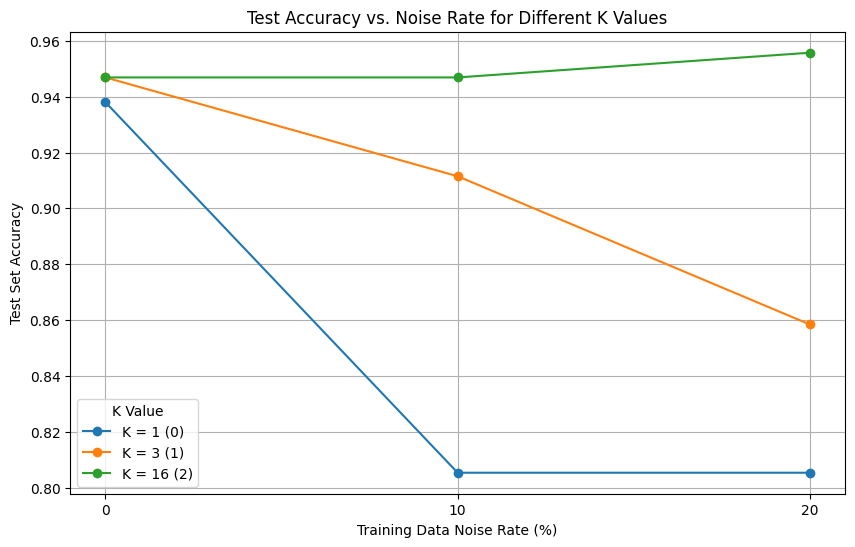

In [ ]:
# --- Configuration ---
# REPLACE THIS VALUE with your actual optimal K from Step 3 (Scaled, All Features)
optimal_k_for_scaled_data = 3 # Example value, use your result from Step 3
# ---------------------

k_values_to_test = [1, optimal_k_for_scaled_data, 16]
noise_datasets = {
    '0% (Clean)': (X_train_scaled_clean, y_train_clean),
    '10% Noise': (X_train_noisy_10, y_train_noisy_10),
    '20% Noise': (X_train_noisy_20, y_train_noisy_20)
}

results = []

# --- Custom Evaluation Loop ---
for noise_level, (X_train_noise, y_train_noise) in noise_datasets.items():
    
    # Check class distribution to confirm the slight shift:
    bincount_result = np.bincount(y_train_noise.astype(int))
    
    for k in k_values_to_test:
        
        # 1. Train and Predict (using custom knn_predict)
        # Note: In KNN, 'training' is just storing the data (X_train_noise, y_train_noise)
        y_pred = knn_predict(X_train_noise, y_train_noise, X_test_scaled, k)
        
        # 2. Calculate Accuracy (using custom accuracy_score)
        acc = accuracy_score(y_test, y_pred)
        
        # 3. Store Results
        results.append({
            'Noise Level': noise_level,
            'K Value': k,
            'Test Accuracy': acc
        })

# Convert results to a DataFrame for clear display
results_df = pd.DataFrame(results)
print("\n--- Model Performance on Test Set under various Noise Levels ---")
display(results_df.round(4))


# --- Plotting the Sensitivity ---
plt.figure(figsize=(10, 6))
noise_rates = [0, 10, 20] # For X-axis plotting

for k in k_values_to_test:
    # Filter results for the current K value
    k_data = results_df[results_df['K Value'] == k]
    accuracy_scores = k_data['Test Accuracy'].values
    
    plt.plot(noise_rates, accuracy_scores, marker='o', linestyle='-', 
             label=f'K = {k} ({k_values_to_test.index(k)})') 

plt.title('Test Accuracy vs. Noise Rate for Different K Values')
plt.xlabel('Training Data Noise Rate (%)')
plt.ylabel('Test Set Accuracy')
plt.xticks(noise_rates)
plt.legend(title='K Value')
plt.grid(True)
plt.show()

## 6. Selecting the Distance Function (Part III)

The choice of distance metric fundamentally changes how "neighbor" is defined. We compare Euclidean (L2 norm) with Manhattan (L1 norm) and Chebyshev (L∞ norm) distances on the scaled data with the optimal $K$.

### Distance Formulas:
* **Manhattan Distance (L1):** $\sum_{i=1}^{n} |x_{1i} - x_{2i}|$
* **Chebyshev Distance (L∞):** $\max_{i} (|x_{1i} - x_{2i}|)$

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume the Optimal K from Step 3 (Scaled, All Features) is available
# Based on your previous output, K=3 was used as optimal_k_for_scaled_data.
optimal_k_for_scaled_data = 3 

# --- Custom Distance Functions (Re-defined for completeness) ---
def euclidean_distance(x1, x2): return np.sqrt(np.sum((x1 - x2)**2))
def manhattan_distance(x1, x2): return np.sum(np.abs(x1 - x2))
def chebyshev_distance(x1, x2): return np.max(np.abs(x1 - x2))

# --- Generalized KNN Prediction Function (FIX APPLIED HERE) ---
def knn_predict_generalized(X_train, y_train, X_test, k, distance_func):
    """Predicts labels using a specified distance metric."""
    predictions = []
    for x_test_row in X_test:
        distances = []
        for i in range(len(X_train)):
            dist = distance_func(x_test_row, X_train[i]) 
            distances.append((dist, y_train[i]))
            
        distances.sort(key=lambda x: x[0])
        neighbors_labels = [item[1] for item in distances[:k]]
        
        # FIX: Convert list to numpy array before using np.bincount
        counts = np.bincount(np.array(neighbors_labels).astype(int)) 
        
        result = np.argmax(counts)
        predictions.append(result)
    return np.array(predictions)

# --- Final Evaluation with Different Distances (Rest of the previous step) ---

distance_metrics = {
    'Euclidean (L2)': euclidean_distance,
    'Manhattan (L1)': manhattan_distance,
    'Chebyshev (L∞)': chebyshev_distance
}

distance_results = []

# Assuming X_train_scaled, y_train, X_test_scaled, y_test, and evaluate_model are available.
for name, func in distance_metrics.items():
    
    # 1. Prediction on the Test Set
    y_pred = knn_predict_generalized(X_train_scaled, y_train, X_test_scaled, optimal_k_for_scaled_data, func)
    
    # 2. Evaluation
    # Since evaluate_model requires re-predicting, we use the y_pred directly for efficiency
    TP, TN, FP, FN = get_confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(TP, FP)
    rec = recall_score(TP, FN)
    f1 = f1_score(prec, rec)

    distance_results.append({
        'Distance Metric': name,
        'K Value': optimal_k_for_scaled_data,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })

# Convert results to a DataFrame for clear display
distance_df = pd.DataFrame(distance_results)
print("\n--- Performance Comparison for Different Distance Metrics (K=Optimal) ---")
display(distance_df.round(4))


--- Performance Comparison for Different Distance Metrics (K=Optimal) ---


,Distance Metric,K Value,Accuracy,Precision,Recall,F1-Score
0,Euclidean (L2),3,0.9469,0.9286,0.9286,0.9286
1,Manhattan (L1),3,0.9646,0.9524,0.9524,0.9524
2,Chebyshev (L∞),3,0.9292,0.9250,0.8810,0.9024
